In [24]:
import numpy as np
import matplotlib 
from morpheus.classifier import Classifier
from morpheus.data import example
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import pickle
import pystilts

from astropy.nddata import Cutout2D


In [2]:
path = '/net/diva/scratch-ssd1/mhuertas/data/CEERS/'

In [3]:
# catalog
#cat = pd.read_csv(path+"CEERS_SDR3_SAM_input.cat",sep='',header=0)

table = Table.read(path+"CEERS_SDR3_SAM_input.fits")
cat = table.to_pandas()

In [18]:
cat.columns

Index(['haloid', 'galid', 'redshift', 'ra', 'dec', 'm_vir', 'V_vir', 'r_vir',
       'mhalo', 'mstar', 'mcold', 'Zstar', 'Zcold', 'mstardot', 'sfr_ave',
       'meanage', 'angular_size', 'ellipticity', 'pos_angle', 'sersic_index',
       'UV1500_rest', 'UV2300_rest', 'UV2800_rest', 'galex_FUV', 'galex_NUV',
       'acsf435w', 'acsf606w', 'acsf775w', 'acsf814w', 'acsf850lp',
       'wfc3f275w', 'wfc3f336w', 'wfc3f105w', 'wfc3f125w', 'wfc3f160w',
       'NIRCam_F070W', 'NIRCam_F090W', 'NIRCam_F115W', 'NIRCam_F150W',
       'NIRCam_F200W', 'NIRCam_F277W', 'NIRCam_F356W', 'NIRCam_F444W',
       'NIRCam_F140M', 'NIRCam_F162M', 'NIRCam_F182M', 'NIRCam_F210M',
       'NIRCam_F250M', 'NIRCam_F335M', 'NIRCam_F360M', 'NIRCam_F410M',
       'NIRCam_F430M', 'NIRCam_F460M', 'NIRCam_F480M', 'irac_ch1', 'irac_ch2',
       'irac_ch3', 'irac_ch4', 'MIRI_F560W', 'MIRI_F770W', 'MIRI_F1000W',
       'MIRI_F1130W', 'MIRI_F1280W', 'MIRI_F1500W', 'MIRI_F1800W',
       'MIRI_F2100W', 'MIRI_F2550W'],
      dty

In [4]:
ceers = fits.open(path+'ceers5_f150w_i2d.fits.gz')
w = WCS(ceers[1].header)

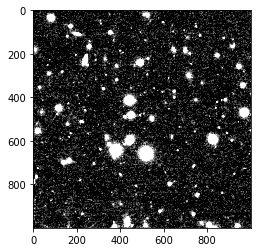

In [43]:
image =  ceers[1].data

# convert to e/s

crop = Cutout2D(image,((2400+3400)/2,(3650+2650)/2),(1000,1000),wcs=w)
cut = image[2650:3650,2400:3400]

plt.imshow(crop.data,vmin=0,vmax=0.01,cmap='gray')


ceers_cutout = ceers[1]
ceers_cutout.data = crop.data

# Update the FITS header with the cutout WCS
ceers_cutout.header.update(crop.wcs.to_header())

# Write the cutout to a new FITS file
cutout_filename = path+'ceers5_f150w_i2d_cutout.fits'
ceers_cutout.writeto(cutout_filename, overwrite=True)


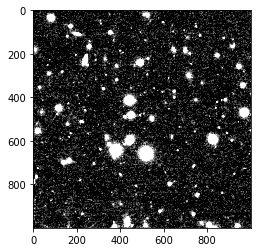

In [34]:
plt.imshow(cut,vmin=0,vmax=0.01,cmap='gray')

In [5]:
catalog = fits.open(path+'CEERS_SDR3_SAM_input.fits')
#cord = SkyCoord(cat.ra,cat.dec,unit="deg")
x,y = w.world_to_array_index_values(cat.ra,cat.dec)


In [6]:
cat['x']=x
cat['y']=y

/tmp/ipykernel_29940/794998848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut.x = cut.x-2650
/tmp/ipykernel_29940/794998848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut.y=cut.y-2400


(array([45., 59., 63., 49., 66., 59., 41., 41., 47., 62.]),
 array([  1. , 100.2, 199.4, 298.6, 397.8, 497. , 596.2, 695.4, 794.6,
        893.8, 993. ]),
 <BarContainer object of 10 artists>)

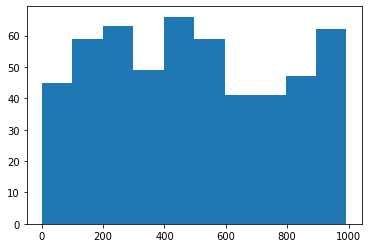

In [7]:
cut = cat.query("2650<x<3650 and 2400<y<3400")
cut.x = cut.x-2650
cut.y=cut.y-2400
plt.hist(cut.x)

In [8]:
cut.to_csv(path+"CEERS_SDR3_SAM_input_cut.csv")

In [9]:
# morpheus catalog

morpheus = pickle.load(open(path+"catalog_morpheus_ceers5_f150w_i2d.pkl",'rb'))
morpheus_df = pd.DataFrame(morpheus)
x_m=[]
y_m=[]

sph=[]
disk=[]
irr=[]
ps=[]

for c,m in zip(morpheus_df.location,morpheus_df.morphology):
    x_m.append(c[0])
    y_m.append(c[1])
    sph.append(m[0])
    disk.append(m[1])
    irr.append(m[2])
    ps.append(m[3])
morpheus_df['x']=np.asarray(x_m)
morpheus_df['y']=np.asarray(y_m)
morpheus_df['sph']=np.asarray(sph)
morpheus_df['disk']=np.asarray(disk)
morpheus_df['irr']=np.asarray(irr)
morpheus_df['ps']=np.asarray(ps)

morpheus_df.to_csv(path+"catalog_morpheus_ceers5_f150w_i2d.csv")

#print((morpheus_df.location[:]))

In [10]:
pystilts.tmatch2(in1=path+"CEERS_SDR3_SAM_input_cut.csv", in2=path+"catalog_morpheus_ceers5_f150w_i2d.csv", out=path+"catalog_morpheus_ceers5_f150w_i2d_matched.csv",
                 matcher='2d', values1='x y', values2='x y',
                 join='1and2', radius='1')

Params: Error(Number)=1.0
Tuning: Bin Factor(Double)=8.0
Processing: Sequential
Attempt to locate restricted common region
Assessing range of coordinates from table 1...................................
Limits are: 1 .. 993, 3 .. 999
Assessing range of coordinates from table 2...................................
Limits are: 18 .. 994, 5 .. 993
Potential match region: 17 .. 994, 4 .. 994
Counting rows in match region for table 1.....................................
524 rows in match region
Counting rows in match region for table 2.....................................
135 rows in match region
Binning rows for table 2......................................................
171 row refs for 135 rows in 171 bins
(average bin occupancy 1.0)
Scanning rows for table 1.....................................................
Eliminating multiple row references...........................................
Elapsed time for match: 0 seconds



In [11]:
matched = pd.read_csv(path+"catalog_morpheus_ceers5_f150w_i2d_matched.csv")
print(len(cut))

532


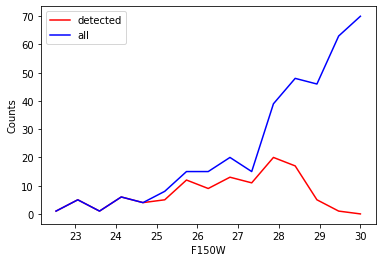

In [20]:
ndet,bins = np.histogram(matched.NIRCam_F150W,bins=15,range=(22,30))
plt.plot(bins[1:],ndet,color='red',label='detected')

nall,bins = np.histogram(cut.NIRCam_F150W,bins=15,range=(22,30))
plt.plot(bins[1:],nall,color='blue',label='all')

plt.legend()
plt.xlabel("F150W")
plt.ylabel("Counts")
plt.savefig(path+"counts_detected.png")

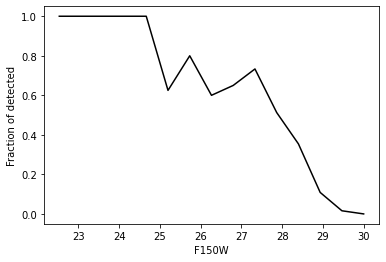

In [21]:
plt.plot(bins[1:],ndet/nall,color='black')
plt.xlabel("F150W")
plt.ylabel("Fraction of detected")
plt.savefig(path+"frac_detected.png")

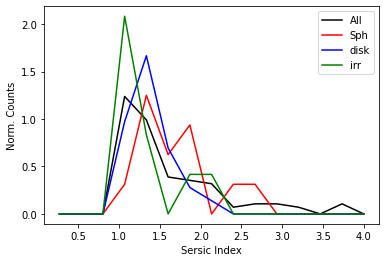

In [22]:
nser,bins = np.histogram(matched.sersic_index,bins=15,range=(0,4),density=True)
plt.plot(bins[1:],nser,color='black',label='All')

sph = matched.query("sph>0.5")
nser,bins = np.histogram(sph.sersic_index,bins=15,range=(0,4),density=True)
plt.plot(bins[1:],nser,color='red',label='Sph')


disk = matched.query("disk>0.5")
nser,bins = np.histogram(disk.sersic_index,bins=15,range=(0,4),density=True)
plt.plot(bins[1:],nser,color='blue',label='disk')

irr = matched.query("irr>0.5")
nser,bins = np.histogram(irr.sersic_index,bins=15,range=(0,4),density=True)
plt.plot(bins[1:],nser,color='green',label='irr')

plt.legend()
plt.xlabel("Sersic Index")
plt.ylabel("Norm. Counts")

plt.savefig(path+"sersic_morph.png")